# Synaptic Transmission Models
Author: Christian Pehle

Synaptic transmission gating function (Hu & Senjowski)
$$
\begin{align*}
\tau \dot{s} &= - s  + g_\epsilon(v) \dot{v} \\
\dot{V} &= f(V, I) \\ 
I       &= W s + \ldots
\end{align*}
$$

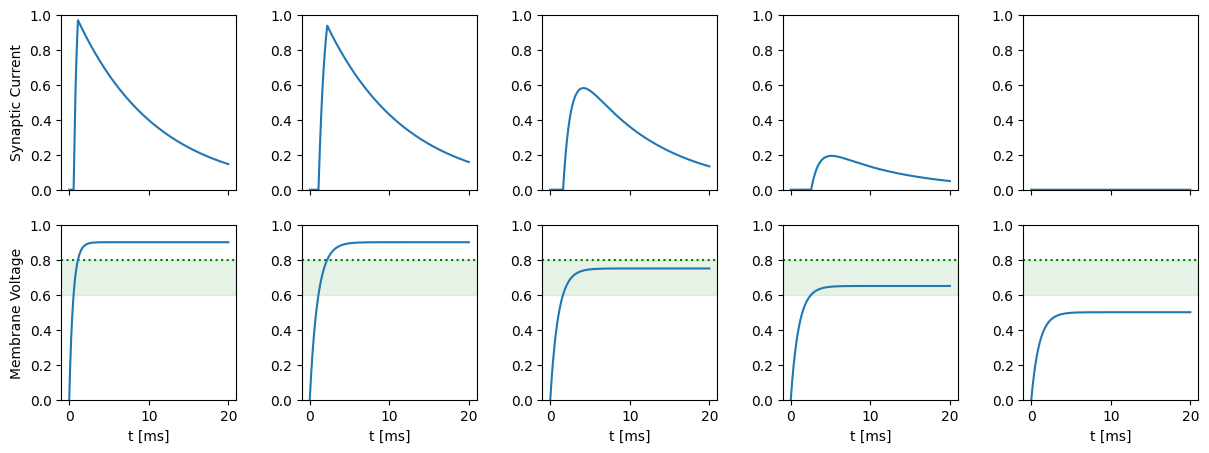

In [1]:
from jaxsnn.base import explicit
from jaxsnn.base import funcutils
from jaxsnn.base.types import ArrayLike

import matplotlib.pyplot as plt
import jax.numpy as np
import tree_math


@tree_math.struct
class ExampleState:
    v: ArrayLike
    s: ArrayLike


def synapse_dynamics(gating_function, g_leak=10.0, v_leak=1.0, tau_s_inv=1.0):
    def dynamics(state: ExampleState):
        v_dot = g_leak * (v_leak - state.v)

        return ExampleState(
            v=v_dot, s=tau_s_inv * (-state.s + gating_function(state.v) * v_dot)
        )

    return dynamics


def heaviside(x):
    return 0.5 + 0.5 * np.sign(x)


def gating_function(theta, threshold):
    def f(v):
        dv = threshold - v
        return heaviside(dv) * heaviside(theta - dv) * 1 / theta

    return f


projection = lambda x: x
dt = 1e-4
inner_steps = 1
outer_steps = 20000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []

theta = 0.2
v_th = 0.8

for v_l, g_l in zip(v_leak, g_leak):
    f = gating_function(theta, v_th)
    dynamics = synapse_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = ExampleState(0.0, 0.0)
    time = 10 * dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]


fig, ax = plt.subplots(
    2, 5, sharex=True, figsize=(5 * 3, 5), subplot_kw=dict(box_aspect=1)
)

for idx in range(5):
    ax[0, idx].set_ylim(0, 1.0)
    # ax[0,idx].set_box_aspect(1)
    ax[1, idx].set_ylim(0, 1.0)
    # ax[1,idx].set_box_aspect(1)
    ax[0, idx].plot(time, actuals[idx].s)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)
    if idx == 0:
        ax[1, idx].set_ylabel("Membrane Voltage")
        ax[0, idx].set_ylabel("Synaptic Current")
    ax[1, idx].set_xlabel("t [ms]")

The same principle also applies to other synaptic transmission models. Consider for example
$$
\begin{align*}
\tau_a \dot{a} &= -a + g_\epsilon(v_p) \eta \dot{v}_p \\
\tau_b \dot{b} &= -b + g_\epsilon(v_p) \eta \dot{v}_p \\
g_s(a,b)       &= \bar{g}_s (b - a) \\
I              &= g_s(a, b) (e_s - v_t)
\end{align*}
$$

where $v_t$ denotes the membrane voltage in the post-synaptic neuron and $v_p$ denotes the membrane voltage in the pre-synaptic neuron, $e_s$ is the equilibrium potential for the synaptic transmission and $\eta(\tau_a, \tau_b)$ is scale factor, such that $g_s(a,b)$ reaches its maximum at $\bar{g}_s$. 

In [2]:
from jaxsnn.channels.synapse import (
    voltage_gated_dynamics,
    martinotti_gaba_parameters,
    SynapseParameters,
    SynapseState,
)


@tree_math.struct
class State:
    v: ArrayLike
    s: SynapseState


def synapse_dynamics(gating_function, p: SynapseParameters, g_leak=10.0, v_leak=1.0):
    vg_dyn = voltage_gated_dynamics(gating_function=gating_function)

    def dynamics(state: State):
        v_dot = g_leak * (v_leak - state.v)
        return State(v=v_dot, s=vg_dyn(state.s, v_dot=v_dot, v=state.v, p=p))

    return dynamics

In [11]:
projection = lambda x: x
dt = 1e-4
inner_steps = 1
outer_steps = 200000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [10.0, 5.0, 5.0, 5.0, 5.0]
actuals = []
theta = 0.2
v_th = 0.8

for v_l, g_l in zip(v_leak, g_leak):
    f = gating_function(theta, v_th)
    dynamics = synapse_dynamics(f, p=martinotti_gaba_parameters, v_leak=v_l, g_leak=g_l)
    initial_state = State(0.0, SynapseState(0.0, 0.0))
    time = 10 * dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]

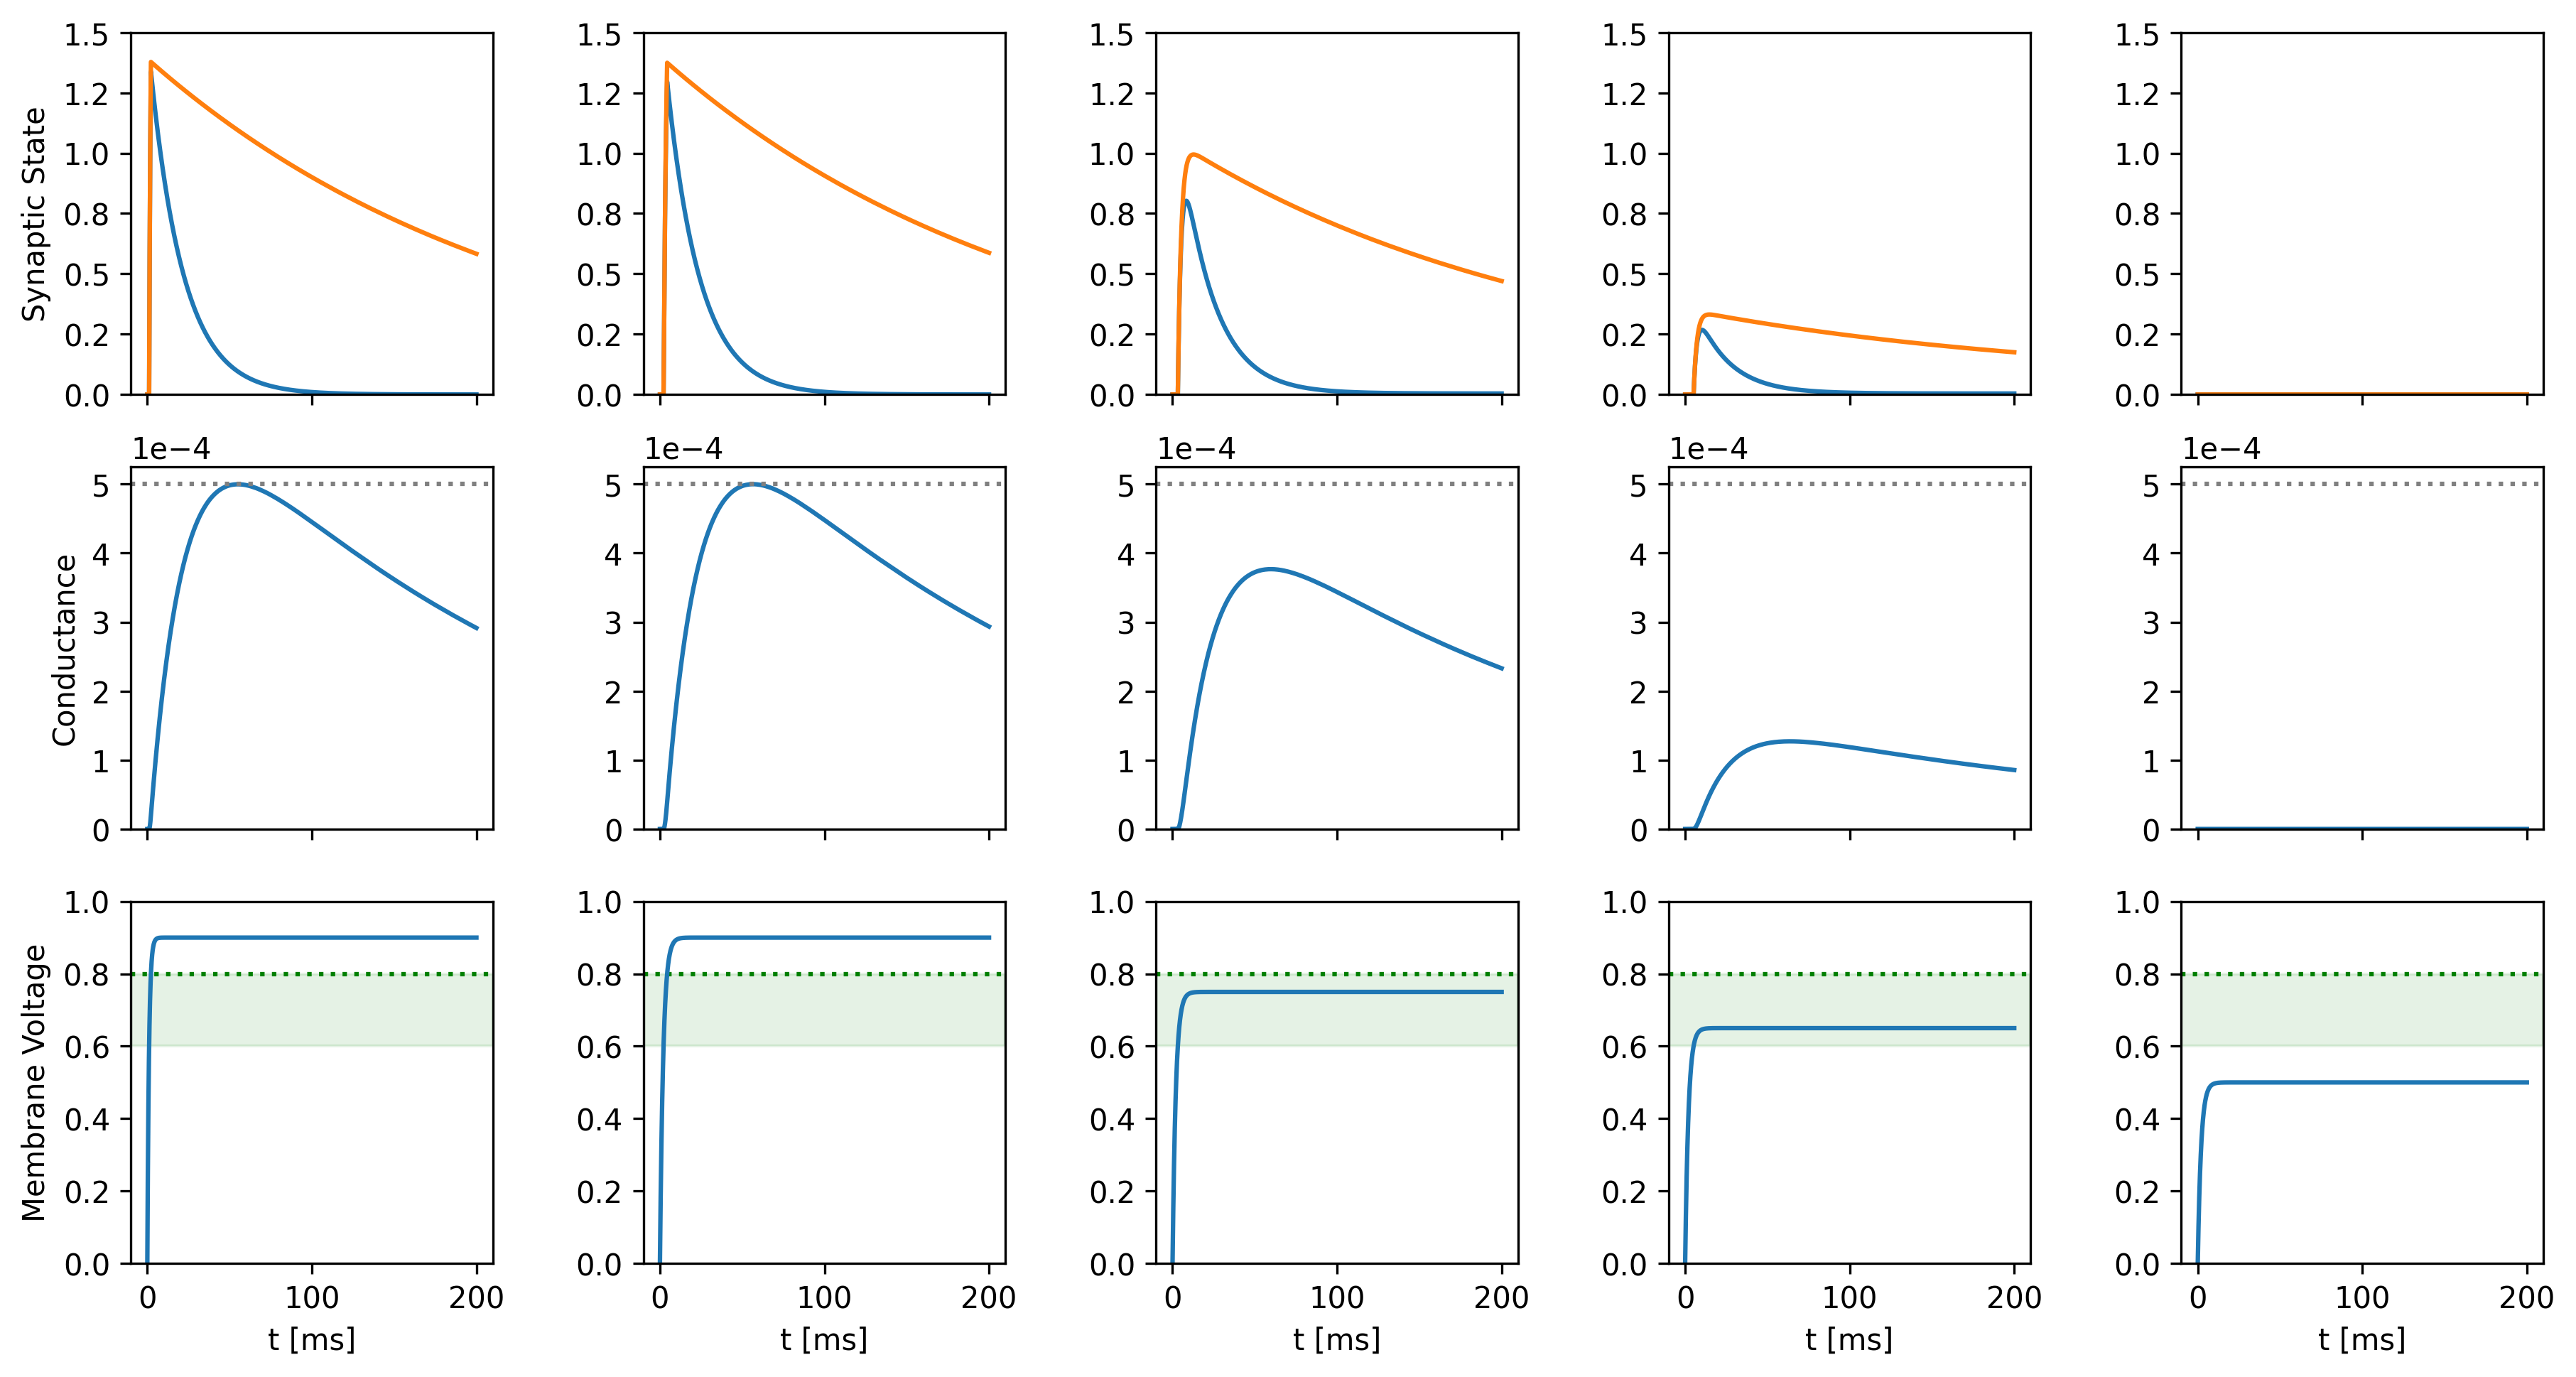

In [12]:
from jaxsnn.channels.synapse import g_syn
from matplotlib.ticker import FormatStrFormatter


fig, ax = plt.subplots(
    3, 5, sharex=True, figsize=(5 * 3, 5 * 1.5), subplot_kw=dict(box_aspect=1), dpi=300
)

for idx in range(5):
    ax[0, idx].set_ylim(0, 1.5)
    ax[0, idx].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax[0,idx].set_box_aspect(1)
    ax[1, idx].set_ylim(0, martinotti_gaba_parameters.g_max * 1.05)
    ax[1, idx].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax[2, idx].set_ylim(0, 1.0)
    # ax[1,idx].set_box_aspect(1)
    ax[0, idx].plot(time, actuals[idx].s.a)
    ax[0, idx].plot(time, actuals[idx].s.b)
    ax[1, idx].plot(time, g_syn(actuals[idx].s, martinotti_gaba_parameters))
    ax[1, idx].axhline(
        martinotti_gaba_parameters.g_max, color="grey", linestyle="dotted"
    )
    ax[2, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[2, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[2, idx].plot(time, actuals[idx].v)
    if idx == 0:
        ax[2, idx].set_ylabel("Membrane Voltage")
        ax[1, idx].set_ylabel("Conductance")
        ax[0, idx].set_ylabel("Synaptic State")
    ax[2, idx].set_xlabel("t [ms]")

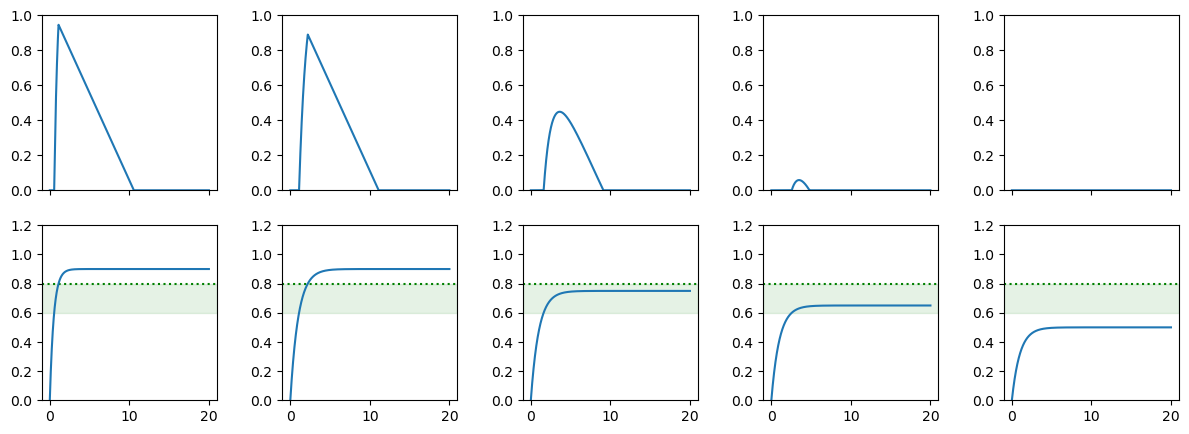

In [ ]:
def refractory_dynamics(gating_function, g_leak=10.0, v_leak=1.0, tau_s_inv=1.0):
    def dynamics(state: ExampleState):
        v_dot = g_leak * (v_leak - state.v)
        return ExampleState(
            v=v_dot,
            s=tau_s_inv * (-heaviside(state.s) + gating_function(state.v) * v_dot),
        )

    return dynamics


projection = lambda x: x
dt = 1e-4
inner_steps = 1
outer_steps = 20000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []

theta = 0.2
v_th = 0.8

for v_l, g_l in zip(v_leak, g_leak):
    f = gating_function(theta, v_th)
    dynamics = refractory_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = ExampleState(0.0, 0.0)
    time = 10 * dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]


fig, ax = plt.subplots(
    2, 5, sharex=True, figsize=(5 * 3, 5), subplot_kw=dict(box_aspect=1)
)

for idx in range(5):
    ax[0, idx].set_ylim(0, 1.0)
    ax[1, idx].set_ylim(0, 1.0)
    ax[0, idx].plot(time, actuals[idx].s)
    ax[1, idx].set_ylim(0, 1.2)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)

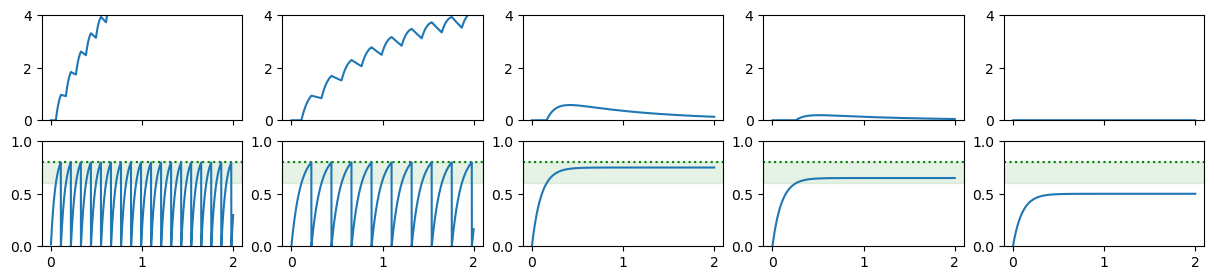

In [ ]:
def threshold_project(v_th):
    def projection(s: ExampleState):
        return ExampleState(v=np.where(s.v > v_th, np.zeros_like(s.v), s.v), s=s.s)

    return projection


dt = 1e-3
inner_steps = 1
outer_steps = 2000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []
v_th = 0.8
theta = 0.2


for v_l, g_l in zip(v_leak, g_leak):
    v_th = 0.8
    f = gating_function(theta, v_th)
    projection = threshold_project(v_th)
    dynamics = synapse_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = ExampleState(0.0, 0.0)
    time = dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]

fig, ax = plt.subplots(2, 5, sharex=True, figsize=(5 * 3, 3))

for idx in range(len(v_leak)):
    ax[0, idx].set_ylim(0, 4.0)
    ax[1, idx].set_ylim(0, 1.0)
    ax[0, idx].plot(time, actuals[idx].s)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)

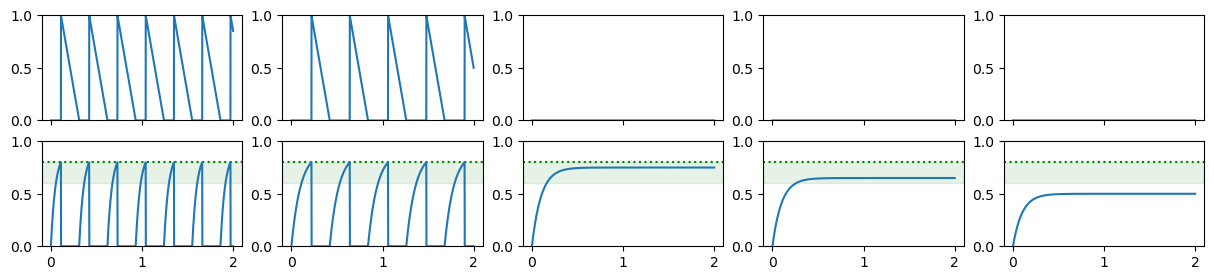

In [ ]:
@tree_math.struct
class RefractoryNeuron:
    v: ArrayLike
    s: ArrayLike
    r: ArrayLike


def refractory_dynamics(
    gating_function,
    g_reset=50.0,
    v_reset=0.0,
    g_leak=10.0,
    v_leak=1.0,
    tau_s_inv=1.0,
    tau_refrac_inv=5.0,
):
    def dynamics(state: RefractoryNeuron):
        v_dot = (1 - heaviside(state.r)) * g_leak * (v_leak - state.v)
        return RefractoryNeuron(
            v=v_dot,
            s=tau_s_inv * (-state.s + gating_function(state.v) * v_dot),
            r=tau_refrac_inv * (-heaviside(state.r)),
        )

    return dynamics


def threshold_project(v_th):
    def projection(s: RefractoryNeuron):
        return RefractoryNeuron(
            v=np.where(s.v > v_th, np.zeros_like(s.v), s.v),
            s=s.s,
            r=np.where(s.v > v_th, s.r + 1, s.r),
        )

    return projection


dt = 1e-3
inner_steps = 1
outer_steps = 2000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []
v_th = 0.8
theta = 0.2

for v_l, g_l in zip(v_leak, g_leak):
    v_th = 0.8
    f = gating_function(theta, v_th)
    projection = threshold_project(v_th)
    dynamics = refractory_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = RefractoryNeuron(0.0, 0.0, 0.0)
    time = dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]

fig, ax = plt.subplots(2, 5, sharex=True, figsize=(5 * 3, 3))

for idx in range(len(v_leak)):
    ax[0, idx].set_ylim(0, 1.0)
    ax[1, idx].set_ylim(0, 1.0)
    ax[0, idx].plot(time, actuals[idx].r)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)